In [1]:
import sys
sys.path.insert(0, '../../flygenvectors/')

import os
import numpy as np
from glob import glob
import scipy.io as sio
from scipy import sparse, signal

from sklearn.decomposition import PCA, FastICA
# from skimage.restoration import denoise_tv_chambolle

import matplotlib.pyplot as plt
from matplotlib import axes, gridspec, colors

import matplotlib.pylab as pl
import seaborn as sns
from scipy.stats import zscore
import data as dataUtils
import plotting
import flygenvectors.ssmutils as utils

from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import r2_score

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')


In [2]:
sns.set_style("white")
sns.set_context("talk")
plot_dark = True

doDetrend = False
doZscore = False

### load data

In [3]:
main_dir = '/Users/evan/Dropbox/_AxelLab/_flygenvectors_dataShare/'

# expt_id = '2019_06_30_fly1'
exp_date = '2018_08_24' 
fly_num = 'fly3_run1'

# options
# '180824_f3r1'
# '2019_06_26_fly2'
# '2019_06_28_fly2'
# '2019_06_30_fly1'
# '2019_07_01_fly2'

exp_folder = exp_date + '_' + fly_num + '/'
file_name_main = exp_date + '*' + fly_num + '.npz'
file_name_A = exp_date + '*' + fly_num + '_A.npz'

fig_folder = main_dir + exp_folder + 'figures/LRclusters/'

file_path_main = glob(main_dir+exp_folder+file_name_main)[0]
# file_path_main = os.path.join(main_dir, exp_folder, file_name_main)
mat_contents = np.load(file_path_main)
# file_path_A = os.path.join(main_dir, exp_folder, file_name_A)
file_path_A = glob(main_dir+exp_folder+file_name_A)[0]
A = sparse.load_npz(file_path_A)
im = np.squeeze(mat_contents['im'])

if not os.path.exists(fig_folder):
    os.mkdir(fig_folder)


In [4]:

# get data from matlab dict
behavior = np.squeeze(mat_contents['ball'])
trialFlag = np.squeeze(mat_contents['trialFlag'])
dlc_behav = np.squeeze(mat_contents['dlc'])
time = np.squeeze(mat_contents['time'])
dFF = np.squeeze(mat_contents['dFF'])
dims = np.squeeze(mat_contents['dims'])
dims_in_um = mat_contents['dims_in_um']
background_im = mat_contents['im']
scanRate = mat_contents['scanRate']

### remove cells with probable motion artifacts

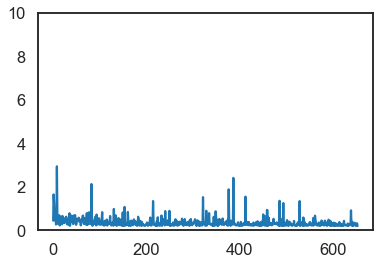

In [6]:
motionThreshold = 10 # signal this large is probably artifact
mx = np.amax(dFF,axis=1)
plt.figure
plt.plot(mx)
plt.ylim(0,motionThreshold)
motionFlag = mx<motionThreshold
dFF = dFF[motionFlag,:]
A = A[:,motionFlag]


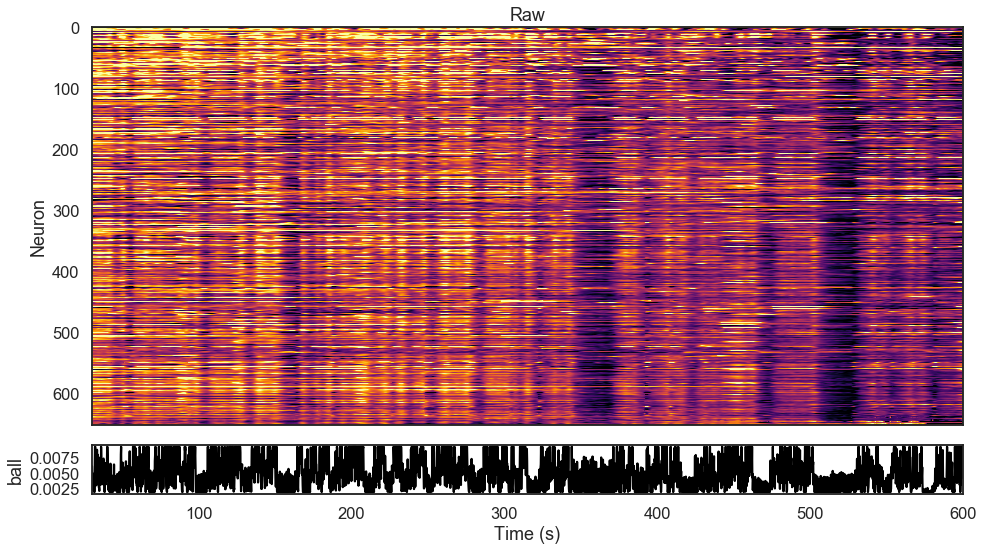

In [7]:
# preprocess
bmin = np.quantile(behavior, 0.1)
bmax = np.quantile(behavior, 0.9)
behavior[behavior<bmin]=bmin
behavior[behavior>bmax]=bmax

# data_run = zscore(dFF)
# data_run = signal.detrend(data_run, axis=0)
dFFc = dFF.copy() #dataUtils.cluster(dFF)

dt = time[1]-time[0]
tPl = time[0]+np.linspace(0,dt*len(time),len(time))

nDLCpts=8 #np.shape(dlc_behav)[1]/3
colors = pl.cm.jet(np.linspace(0,1,nDLCpts))

vmin = np.quantile(dFFc, 0.01)
vmax = np.quantile(dFFc, 0.95)
dFFc[dFFc<vmin]=vmin
dFFc[dFFc>vmax]=vmax

# plt.figure(figsize=(12, 28))
f, axes = plt.subplots(2,1,gridspec_kw={'height_ratios':[8,1]},figsize=(14, 8))
#f.set_figsize([12,12])
#plt.subplot(121)



axes[0].imshow(
    dFF, aspect='auto', 
    cmap='inferno', vmin=vmin, vmax=vmax)
plt.sca(axes[0])
plt.title('Raw')
axes[0].set_xlim([0,len(behavior)])
plt.xticks([])
plt.ylabel('Neuron')

    

plt.sca(axes[-1])
axes[-1].plot(tPl,behavior,'k')
axes[-1].set_xlim([min(tPl),max(tPl)])
axes[-1].set_ylabel('ball')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

In [104]:
# find optimal time constant PER NEURON with which to filter ball trace to maximize correlation

behavior = np.squeeze(behavior)
x = np.array([i for i in range(500)])

tauList = np.logspace(np.log10(scanRate),np.log10(100*scanRate),num=200)
# tauList = np.logspace(0,5,num=300) #range(10,1000,10)
a = np.zeros((dFFc.shape[0],len(tauList)))
for i in range(len(tauList)):
    print(i, end =" ")
    cTau = tauList[i]
    eFilt = np.exp(-x/cTau)

    c = np.convolve(eFilt,behavior,'valid')#,'same')
    for j in range(dFFc.shape[0]):
        a[j,i] = np.corrcoef(dFFc[j,len(eFilt)-1:], c)[0,1] 


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

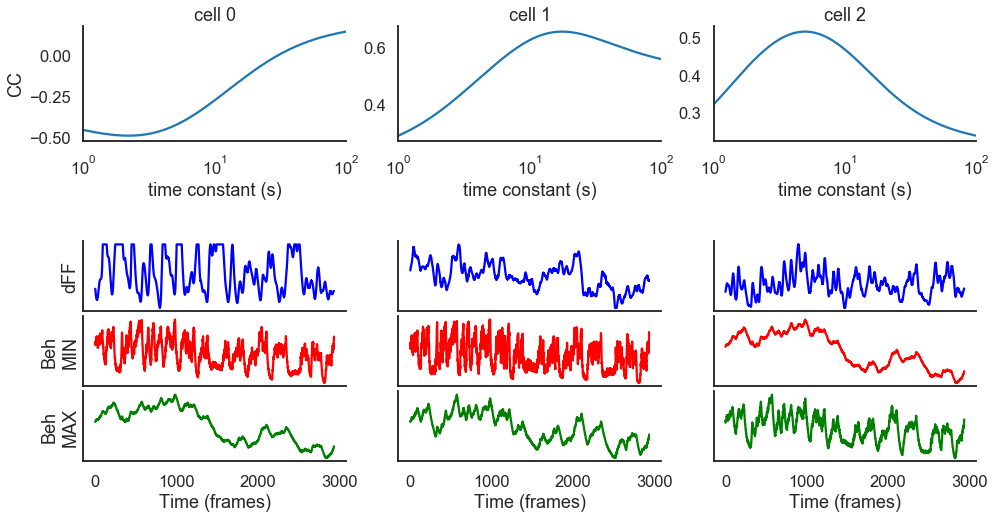

In [111]:
# show example cells
from matplotlib.gridspec import GridSpec


cell_ids = [232,250,253]
#,constrained_layout=True
fig = plt.figure(figsize=(16,8))
# f, axes = plt.subplots(4,len(cell_ids),gridspec_kw={'height_ratios':[2,1,1,1]},hspace=[.5,.2,.2,.2],figsize=(14, 8))
gs0 = GridSpec(4,len(cell_ids), height_ratios=[3.,1.,1.,1.],hspace=1.2) #,hspace=[.5,.2,.2,.2]
gs = GridSpec(4,len(cell_ids), height_ratios=[3.,1.,1.,1.],hspace=.05) #,hspace=[.5,.2,.2,.2]

for j in range(len(cell_ids)):
    cell_id = cell_ids[j]
    axes[0,j] = fig.add_subplot(gs0[j])
    #plt.subplot(3,len(cell_ids),j+1)
    axes[0,j].plot(tauList/scanRate,a[cell_id,:],label='CC')
    axes[0,j].set_xscale('log')
    axes[0,j].set_xlim((tauList[0]/scanRate,tauList[-1]/scanRate))
    axes[0,j].set_xlabel('time constant (s)')
    axes[0,j].set_title('cell '+str(j))
    axes[0,j].spines['top'].set_visible(False)
    axes[0,j].spines['right'].set_visible(False)
    if(j==0):
        axes[0,j].set_ylabel('CC')
        #axes[0,j].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    mn = np.argmin(a[cell_id,:])
    mx = np.argmax(a[cell_id,:])

    x = np.array([i for i in range(500)])
    cTau = tauList[mn]
    eFilt = np.exp(-x/cTau)
    c = np.convolve(eFilt,behavior,'valid')#,'same')
    #print(np.corrcoef(dFFc[cell_id,len(eFilt)-1:], c)[0,1])

    axes[1,j] = fig.add_subplot(gs[len(cell_ids)+j])
    #plt.subplot(3,len(cell_ids),len(cell_ids)+1+j)
    npl = dFFc[cell_id,len(eFilt)-1:]
    axes[1,j].plot(-1+(npl-npl.min())/(npl.max()-npl.min()),'b',label='dFF')
    axes[1,j].set_xticks([])
    axes[1,j].set_yticks([])
    axes[1,j].spines['top'].set_visible(False)
    axes[1,j].spines['right'].set_visible(False)
    if(j==0):
        axes[1,j].set_ylabel('dFF')
        #axes[1,j].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    axes[2,j] = fig.add_subplot(gs[2*len(cell_ids)+j])
    axes[2,j].plot((c-c.min())/(c.max()-c.min()),'r',label='beh smoothed argmin')
    axes[2,j].set_xticks([])
    axes[2,j].set_yticks([])
    axes[2,j].spines['top'].set_visible(False)
    axes[2,j].spines['right'].set_visible(False)
    if(j==0):
        axes[2,j].set_ylabel('Beh\nMIN')
        #axes[2,j].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    axes[3,j] = fig.add_subplot(gs[3*len(cell_ids)+j])
    #plt.subplot(3,len(cell_ids),2*len(cell_ids)+1+j)
    cTau = tauList[mx]
    eFilt = np.exp(-x/cTau)
    c = np.convolve(eFilt,behavior,'valid')#,'same')
    #plt.plot(-1+(npl-npl.min())/(npl.max()-npl.min()),'b',label='dFF')
    axes[3,j].plot((c-c.min())/(c.max()-c.min()),'g',label='beh smoothed argmax')
    axes[3,j].set_yticks([])
    axes[3,j].spines['top'].set_visible(False)
    axes[3,j].spines['right'].set_visible(False)
    axes[3,j].set_xlabel('Time (frames)')
    if(j==0):
        axes[3,j].set_ylabel('Beh\nMAX')
        #axes[3,j].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

#gs.tight_layout()
#plt.subplots_adjust(hspace = 1.5)
plt.show()

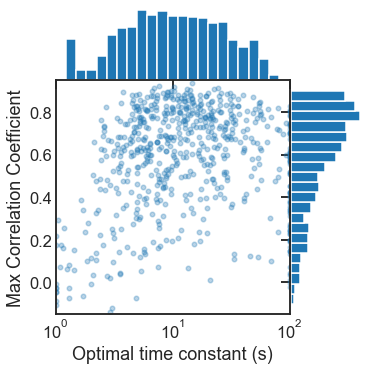

In [106]:
plt.figure(figsize=(5, 5))
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histx.set_xscale('log')
ax_histx.axis('off')
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)
ax_histy.axis('off')


xmin = 1 #4/scanRate
xmax = 100 #1000/scanRate #6000
ymin = -0.15
ymax = 0.95

av = np.max(a,axis=1)
am = np.argmax(a,axis=1)
ax_scatter.scatter(tauList[am]/scanRate,av,marker='.',alpha=0.3)
ax_scatter.set_xscale('log')
ax_scatter.set_xlim((xmin,xmax))
ax_scatter.set_ylim((ymin,ymax))
ax_scatter.set_xlabel('Optimal time constant (s)')
ax_scatter.set_ylabel('Max Correlation Coefficient')

xbinwidth = 100
ybinwidth = 0.05
ybins = np.arange(ymin, ymax, ybinwidth)
xbins = np.logspace(np.log(xmin), np.log(xmax),num=len(ybins),base=np.exp(1))
ax_histx.hist(tauList[am]/scanRate, bins=xbins,log=True)
ax_histy.hist(av, bins=ybins, orientation='horizontal')

# plt.savefig(main_dir + exp_folder + 'figures/'+ exp_date + '_' + fly_num +'_tauScatter.pdf',transparent=True, bbox_inches='tight')

plt.show()

In [107]:
# show location of 'slow' cells, color coded by tau

from matplotlib import cm
cmap = 'hot'
clrs = len(tauList) #np.round(len(tauList)/2).astype(int)
am = np.argmax(a,axis=1)
x = np.linspace(0.0, 1.0, num=clrs)
# c_space = np.linspace(np.quantile(am,.1), np.quantile(am,.9), clrs-2)
# c_space = np.concatenate( ([am.min()],c_space,[am.max()]) )
c_space = np.linspace(-1, len(tauList)+1, num=clrs+2)
rgb_map = np.squeeze(cm.get_cmap(cmap)(x)[np.newaxis, :, :3])

R = np.zeros(dims)
# Asl = A[:,slow_ids]

for j in range(len(c_space)-1):
    cli = np.flatnonzero(  (am>c_space[j]) & (am<c_space[j+1])  )
    if(len(cli)>0):
        A_cli = np.max(A[:,cli], axis=1).toarray()
        R += np.reshape(np.squeeze(A_cli*j), dims, order='F')

[  0.  47.  99. 147. 199.]
['1', '3', '10', '30', '100']


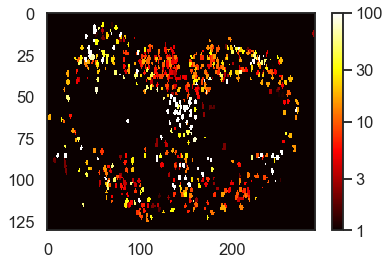

In [108]:
# make COLORBAR for 'slow' cells, color coded by tau
tau_label_list = [1,3,10,30,100]
tau_loc_list = np.zeros(len(tau_label_list))
for i in range(len(tau_label_list)):
    tau_loc_list[i] = np.argmin(np.abs(tauList/scanRate-tau_label_list[i]))
print(tau_loc_list)
print([str(x) for x in tau_label_list])

fig, ax = plt.subplots()
# plt.figure(figsize=(8, 8*totScale))

cs = ax.imshow(np.max(R, axis=2), aspect='auto', cmap=cmap)
cs.set_clim(tau_loc_list[0], tau_loc_list[-1])
cbar = fig.colorbar(cs, ticks=tau_loc_list)
cbar.ax.set_yticklabels([str(x) for x in tau_label_list])

plt.savefig(main_dir + exp_folder + 'figures/'+ exp_date + '_' + fly_num +'_tauMap_colorbar.pdf',transparent=True, bbox_inches='tight')

plt.show()


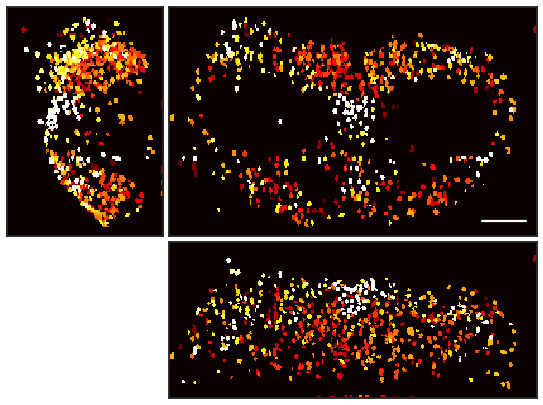

In [115]:
# RGB = RGB/RGB.max()

totScale = 1
totWidth = 1.1*(dims_in_um[2] + dims_in_um[1])
zpx = dims_in_um[2]/totWidth
ypx = dims_in_um[1]/totWidth
xpx = dims_in_um[0]/totWidth

totScale = 1
plt.figure(figsize=(8, 8*totScale))

totWidth = 1.1*(dims_in_um[2] + dims_in_um[1])
zpx = dims_in_um[2]/totWidth
ypx = dims_in_um[1]/totWidth
xpx = dims_in_um[0]/totWidth

ax2 = plt.axes([.05+zpx,  (.05+zpx)/totScale,  ypx,  xpx/totScale])
ax1 = plt.axes([.04,      (.05+zpx)/totScale,  zpx,  xpx/totScale])
ax3 = plt.axes([.05+zpx,  .04/totScale,      ypx,  zpx/totScale])

cs1 = ax1.imshow(np.max(R, axis=1), aspect='auto', cmap=cmap)
cs1.set_clim(tau_loc_list[0], tau_loc_list[-1])
ax1.set_xticks([])
ax1.set_yticks([])
# axes[0, 0].set_title('Side')

cs2 = ax2.imshow(np.max(R, axis=2), aspect='auto', cmap=cmap)
cs2.set_clim(tau_loc_list[0], tau_loc_list[-1])
ax2.set_xticks([])
ax2.set_yticks([])
# axes[0, 1].set_title('Top')

ypx_per_um = dims[1]/dims_in_um[1]
scaleBar_um = 50 #50 um
ax2.plot( dims[1]*.97-(scaleBar_um*ypx_per_um,0), (dims[0]*.93, dims[0]*.93),'w')

cs3 = ax3.imshow( np.max(R, axis=0).T, aspect='auto', cmap=cmap )
cs3.set_clim(tau_loc_list[0], tau_loc_list[-1])
ax3.set_xticks([])
ax3.set_yticks([])
# axes[1, 1].set_title('Front')

plt.savefig(main_dir + exp_folder + 'figures/'+ exp_date + '_' + fly_num +'_tauMap.pdf',transparent=True, bbox_inches='tight')

plt.show()

In [134]:
# show location of 'slow' cells, color coded by CC

from matplotlib import cm
cmap = 'bwr'
clrs = len(tauList) #np.round(len(tauList)/2).astype(int)
am = np.max(a,axis=1)
x = np.linspace(0.0, 1.0, num=clrs)
# c_space = np.linspace(np.quantile(am,.1), np.quantile(am,.9), clrs-2)
# c_space = np.concatenate( ([am.min()],c_space,[am.max()]) )
c_space = np.linspace(-1, 1, num=clrs+2)
rgb_map = np.squeeze(cm.get_cmap(cmap)(x)[np.newaxis, :, :3])

S = np.zeros(dims)
# Asl = A[:,slow_ids]

for j in range(len(c_space)-1):
    cli = np.flatnonzero(  (am>c_space[j]) & (am<c_space[j+1])  )
    print(len(cli), end =" ")
    if(len(cli)>0):
        A_cli = np.max(A[:,cli], axis=1).toarray()
        S += np.reshape(np.squeeze(A_cli*c_space[j]), dims, order='F')

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 2 0 0 0 0 0 1 0 1 1 0 1 1 1 1 1 1 3 1 2 1 2 1 2 3 2 2 4 1 0 4 2 2 1 6 5 3 3 4 2 6 2 1 4 6 5 3 3 2 1 4 3 4 5 4 5 2 4 5 6 7 3 8 5 4 7 4 3 7 8 7 9 7 8 4 5 8 7 5 13 14 6 15 13 9 7 12 8 13 18 7 10 8 13 11 13 12 15 15 15 13 15 15 16 13 8 10 10 14 11 8 3 4 1 1 0 0 0 0 0 0 

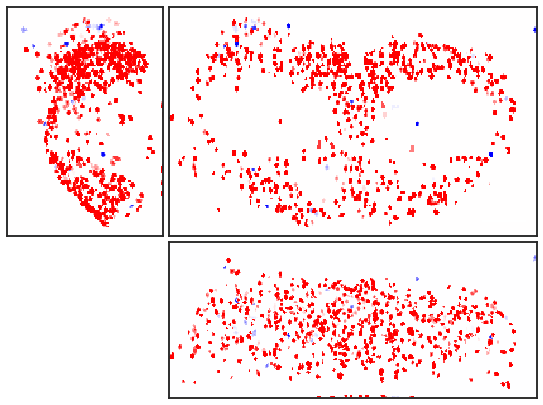

In [137]:
# RGB = RGB/RGB.max()

totScale = 1
totWidth = 1.1*(dims_in_um[2] + dims_in_um[1])
zpx = dims_in_um[2]/totWidth
ypx = dims_in_um[1]/totWidth
xpx = dims_in_um[0]/totWidth

totScale = 1
plt.figure(figsize=(8, 8*totScale))

totWidth = 1.1*(dims_in_um[2] + dims_in_um[1])
zpx = dims_in_um[2]/totWidth
ypx = dims_in_um[1]/totWidth
xpx = dims_in_um[0]/totWidth

ax2 = plt.axes([.05+zpx,  (.05+zpx)/totScale,  ypx,  xpx/totScale])
ax1 = plt.axes([.04,      (.05+zpx)/totScale,  zpx,  xpx/totScale])
ax3 = plt.axes([.05+zpx,  .04/totScale,      ypx,  zpx/totScale])

cs1 = ax1.imshow(np.sum(S, axis=1), aspect='auto', cmap=cmap)
cs1.set_clim(-1, 1)
ax1.set_xticks([])
ax1.set_yticks([])
# axes[0, 0].set_title('Side')

cs2 = ax2.imshow(np.sum(S, axis=2), aspect='auto', cmap=cmap)
cs2.set_clim(-1, 1)
ax2.set_xticks([])
ax2.set_yticks([])
# axes[0, 1].set_title('Top')

ypx_per_um = dims[1]/dims_in_um[1]
scaleBar_um = 50 #50 um
ax2.plot( dims[1]*.97-(scaleBar_um*ypx_per_um,0), (dims[0]*.93, dims[0]*.93),'w')

cs3 = ax3.imshow( np.sum(S, axis=0).T, aspect='auto', cmap=cmap )
cs3.set_clim(-1, 1)
ax3.set_xticks([])
ax3.set_yticks([])
# axes[1, 1].set_title('Front')

# plt.savefig(main_dir + exp_folder + 'figures/'+ exp_date + '_' + fly_num +'_tauMap.pdf',transparent=True, bbox_inches='tight')

plt.show()